## 导入必要的安装包

In [1]:
!pip install tushare
!pip install tqdm
import pandas as pd
import numpy as np
import tushare as ts
import os
from tqdm import tqdm
import glob
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
debug = False
from datetime import datetime
pro = ts.pro_api()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install openpyxl

## 生成Alpha因子的基础函数

In [3]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1


## 一系列Alpha因子

In [4]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap']
        self.volume = daily_info['volume']
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
#         alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
#         alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
#         alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
#         alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
#         alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
#         alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
#         alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
#         alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
#         alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
#         alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
#         alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
#         alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
#         alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close

#         tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
#         alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
#         alpha_dict['alpha30']=tmp2/delay(tmp2,4)

#         tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
#         alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

#         tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
#         alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)

#         alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
#         alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
#         alpha_dict['alpha_total_mv']= daily_info['total_mv']
#         alpha_dict['alpha_pb']= -1*daily_info['pb']
#         alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
#         alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
#         alpha_dict['alpha_vwap']= daily_info['vwap']
#         alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']

        alpha_dict['open'] = daily_info['open']
        alpha_dict['high'] = daily_info['high']
        alpha_dict['low'] = daily_info['low']
        alpha_dict['close'] = daily_info['close']
#         alpha_dict['vwap'] = daily_info['vwap']
        alpha_dict['volume'] = daily_info['volume']
#         alpha_dict['amount'] = daily_info['amount']

        return alpha_dict


## 生成训练集

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# pro = ts.pro_api()
# all_stock = pro.stock_basic()
# price_PD_total = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/price_PD.csv', dtype = {'trade_date': 'str'})
# price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
# all_stock = all_stock[['ts_code','name','market','industry']]
# price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
# price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
#        'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
# price_PD_total = price_PD_total[price_PD_total.market.isin(['创业板'])]
# price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

from google.colab import drive
drive.mount('/content/drive')

pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

Mounted at /content/drive


In [6]:
ss = price_PD_total.groupby('ts_code')['close'].count()
ss

,close
ts_code,
000001.SZ,1475
000002.SZ,1475
000006.SZ,1475
000007.SZ,1471
000008.SZ,1475
...,...
605580.SH,835
605588.SH,840
605589.SH,842


In [8]:
ss = price_PD_total.groupby('ts_code')['close'].count()
len(ss[ss==1475].index.tolist())

2258

In [9]:
price_PD_total.head()

,ts_code,name,market,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,平安银行,主板,银行,20190102,9.39,9.42,9.16,9.19,9.38,-0.19,-2.0256,539386.32,498695.109
1,000001.SZ,平安银行,主板,银行,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707
2,000001.SZ,平安银行,主板,银行,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888
3,000001.SZ,平安银行,主板,银行,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430
4,000001.SZ,平安银行,主板,银行,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795


In [10]:
price_PD_total = price_PD_total[price_PD_total.ts_code.isin(ss[ss==1475].index.tolist())]
# price_PD_total = price_PD_total[price_PD_total.ts_code.isin(ss.index.tolist())]

In [11]:
price_PD_total.ts_code.nunique()

2258

In [12]:
price_PD_total.head(5)

,ts_code,name,market,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,平安银行,主板,银行,20190102,9.39,9.42,9.16,9.19,9.38,-0.19,-2.0256,539386.32,498695.109
1,000001.SZ,平安银行,主板,银行,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707
2,000001.SZ,平安银行,主板,银行,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888
3,000001.SZ,平安银行,主板,银行,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430
4,000001.SZ,平安银行,主板,银行,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795


In [13]:
daily_basic = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/daily_basic.csv', dtype = {'trade_date': 'str'})
daily_basic

,ts_code,trade_date,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,000001.SZ,20190102,0.3141,0.7088,0.99,6.8048,6.4428,0.7330,1.4917,1.4012,1.4799,1.4799,1.717041e+06,1.717025e+06,761029.0923,1.577961e+07,1.577946e+07
1,000001.SZ,20190103,0.2420,0.5460,0.76,6.8714,6.5059,0.7402,1.5063,1.4149,1.4655,1.4655,1.717041e+06,1.717025e+06,761029.0923,1.593414e+07,1.593399e+07
2,000001.SZ,20190104,0.8626,1.9463,2.87,7.2194,6.7456,0.7607,1.5825,1.4343,1.3949,1.3949,1.717041e+06,1.717025e+06,761029.0923,1.674115e+07,1.674099e+07
3,000001.SZ,20190107,0.5042,1.1375,1.19,7.2120,6.7386,0.7599,1.5809,1.4329,1.3963,1.3963,1.717041e+06,1.717025e+06,761029.0923,1.672398e+07,1.672382e+07
4,000001.SZ,20190108,0.2344,0.5287,0.52,7.1528,6.6833,0.7536,1.5679,1.4211,1.4079,1.4079,1.717041e+06,1.717025e+06,761029.0923,1.658662e+07,1.658646e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718158,920128.BJ,20250122,5.5613,5.5613,0.87,50.1866,48.6791,4.2442,3.9764,3.7950,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.277380e+05,4.796550e+04
6718159,920128.BJ,20250123,5.8266,5.8266,1.02,49.9898,48.4882,4.2276,3.9608,3.7802,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.268449e+05,4.777740e+04
6718160,920128.BJ,20250124,3.9659,3.9659,0.74,49.7393,48.2453,4.2064,3.9409,3.7612,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.257082e+05,4.753800e+04
6718161,920128.BJ,20250127,3.0706,3.0706,0.61,49.6856,48.1932,4.2018,3.9367,3.7572,NaN,NaN,8.119000e+03,1.710000e+03,1710.0000,2.254646e+05,4.748670e+04


In [14]:
# price_PD_total = pd.merge(price_PD_total,daily_basic,how='left',on=['ts_code','trade_date'])


In [15]:
##计算开盘涨幅
price_PD_total['open_up'] = price_PD_total.groupby('ts_code').open.shift(1)/price_PD_total.groupby('ts_code').close.shift(0)

In [16]:
price_PD_total.head()

,ts_code,name,market,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,open_up
0,000001.SZ,平安银行,主板,银行,20190102,9.39,9.42,9.16,9.19,9.38,-0.19,-2.0256,539386.32,498695.109,NaN
1,000001.SZ,平安银行,主板,银行,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707,1.011853
2,000001.SZ,平安银行,主板,银行,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888,0.941538
3,000001.SZ,平安银行,主板,银行,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430,0.948665
4,000001.SZ,平安银行,主板,银行,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795,1.018634


In [17]:

#t收盘买 t+1收盘卖
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0)
#t+1开盘买 t+2收盘卖
price_PD_total['ret2'] = price_PD_total.groupby('ts_code').close.shift(-2)/price_PD_total.groupby('ts_code').open.shift(-1)
#t+1开盘买 t+2开盘卖
# price_PD_total['ret3'] = price_PD_total.groupby('ts_code').open.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+3收盘卖
# price_PD_total['ret4'] = price_PD_total.groupby('ts_code').close.shift(-3)/price_PD_total.groupby('ts_code').open.shift(-1)
# #t+1开盘买 t+4收盘卖
# price_PD_total['ret5'] = price_PD_total.groupby('ts_code').close.shift(-4)/price_PD_total.groupby('ts_code').open.shift(-1)

price_PD_total['ret'] = price_PD_total['ret2'].copy()



In [18]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1)


In [19]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [22]:
alpha_dict.keys()

dict_keys(['open', 'high', 'low', 'close', 'volume'])

In [23]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['ts_code', 'trade_date'])

100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


In [24]:
data.head()

,ts_code,trade_date,open,high,low,close,volume
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11


In [25]:
data = pd.merge(data, price_PD_total[['trade_date', 'ts_code','name', 'ret1', 'ret2', \
                                    'ret','open_up']], how='left', on=['trade_date', 'ts_code'])

In [26]:
data

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32,平安银行,1.009793,1.062092,1.062092,NaN
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95,平安银行,1.050647,1.054113,1.054113,1.011853
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06,平安银行,0.998974,0.981707,0.981707,0.941538
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66,平安银行,0.991786,1.021583,1.021583,0.948665
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11,平安银行,1.028986,1.036961,1.036961,1.018634
...,...,...,...,...,...,...,...,...,...,...,...,...
3330545,603999.SH,20250122,5.94,5.96,5.85,5.88,74264.00,读者传媒,1.010204,1.021812,1.021812,1.022109
3330546,603999.SH,20250123,5.96,6.04,5.90,5.94,82529.00,读者传媒,1.025253,1.032095,1.032095,1.000000
3330547,603999.SH,20250124,5.92,6.09,5.85,6.09,93788.00,读者传媒,1.003284,1.021311,1.021311,0.978654
3330548,603999.SH,20250127,6.10,6.23,6.09,6.11,87004.00,读者传媒,1.019640,NaN,NaN,0.968903


In [28]:
data = data[~data.close.isna()].reset_index(drop=True)
len(data.ts_code.unique())

2258

In [29]:
train = data.copy()
# train = train[train.trade_date < '20240101']#.dropna()

train['ret_rank'] = train.groupby('trade_date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

# from sklearn.model_selection import KFold,GroupKFold,train_test_split

# kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

# enumsplit = []
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
#     enumsplit.append([trn_ind, val_ind])
# enumsplit

In [30]:
train.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'volume',
       'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [31]:
# features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
#        'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
#        'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
#        'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
#        'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
#        'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
#        'alpha_dv_ttm']

# features = ['open', 'high', 'low', 'close', 'volume']
features = ['open_up', 'volume' ]


In [32]:
train

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32,平安银行,1.009793,1.062092,1.062092,NaN,0.925155
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95,平安银行,1.050647,1.054113,1.054113,1.011853,0.538530
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06,平安银行,0.998974,0.981707,0.981707,0.941538,0.067316
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66,平安银行,0.991786,1.021583,1.021583,0.948665,0.862932
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11,平安银行,1.028986,1.036961,1.036961,1.018634,0.937998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326029,603999.SH,20250120,6.00,6.07,5.91,5.98,85506.00,读者传媒,0.996656,0.978369,0.978369,0.988294,0.463685
3326030,603999.SH,20250121,6.01,6.05,5.87,5.96,74969.00,读者传媒,0.986577,1.000000,1.000000,1.006711,0.691763
3326031,603999.SH,20250122,5.94,5.96,5.85,5.88,74264.00,读者传媒,1.010204,1.021812,1.021812,1.022109,0.872896
3326032,603999.SH,20250123,5.96,6.04,5.90,5.94,82529.00,读者传媒,1.025253,1.032095,1.032095,1.000000,0.895926


In [33]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())


In [34]:
train.head()

,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,000001.SZ,20190102,9.39,9.42,9.16,9.19,539386.32,平安银行,1.009793,1.062092,1.062092,1.000015,0.925155
1,000001.SZ,20190103,9.18,9.33,9.15,9.28,415537.95,平安银行,1.050647,1.054113,1.054113,1.011853,0.538530
2,000001.SZ,20190104,9.24,9.82,9.22,9.75,1481159.06,平安银行,0.998974,0.981707,0.981707,0.941538,0.067316
3,000001.SZ,20190107,9.84,9.85,9.63,9.74,865687.66,平安银行,0.991786,1.021583,1.021583,0.948665,0.862932
4,000001.SZ,20190108,9.73,9.74,9.62,9.66,402388.11,平安银行,1.028986,1.036961,1.036961,1.018634,0.937998


In [35]:
# test = data.copy()
# test = test[test.trade_date > '20230101']
# test.replace([np.inf, -np.inf], np.nan,inplace=True)
# test[features] = test[features].fillna(train[features].mean())


In [36]:
# from sklearn.preprocessing import QuantileTransformer

# train_nn=train[features].copy()
# test_nn=test[features].copy()
# qt_train = []
# for col in features:
#     qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
#     train_nn[col] = qt.fit_transform(train_nn[[col]])
#     test_nn[col] = qt.transform(test_nn[[col]])
#     qt_train.append(qt)

In [37]:
y = train['ret_rank']

In [38]:
train.columns

Index(['ts_code', 'trade_date', 'open', 'high', 'low', 'close', 'volume',
       'name', 'ret1', 'ret2', 'ret', 'open_up', 'ret_rank'],
      dtype='object')

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 示例DataFrame结构：['stock_id', 'date', 'factor1', 'factor2', ..., 'future_return']
# 假设df已经加载并准备好了

# 数据预处理
# 1. 特征标准化
df = train.copy()
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


In [42]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df, verbose=True)

Memory usage after optimization is: 139.57 MB
Decreased by 57.7%


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326034 entries, 0 to 3326033
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ts_code     object 
 1   trade_date  object 
 2   open        float16
 3   high        float16
 4   low         float16
 5   close       float16
 6   volume      float16
 7   name        object 
 8   ret1        float16
 9   ret2        float16
 10  ret         float16
 11  open_up     float16
 12  ret_rank    float16
dtypes: float16(10), object(3)
memory usage: 139.6+ MB


In [44]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank
0,000001.SZ,20190102,9.390625,9.421875,9.156250,9.187500,0.812500,平安银行,1.009766,1.062500,1.062500,0.000000,0.925293
1,000001.SZ,20190103,9.179688,9.328125,9.148438,9.281250,0.523926,平安银行,1.050781,1.053711,1.053711,0.293457,0.538574
2,000001.SZ,20190104,9.242188,9.820312,9.218750,9.750000,3.005859,平安银行,0.999023,0.981934,0.981934,-1.450195,0.067322
3,000001.SZ,20190107,9.843750,9.851562,9.632812,9.742188,1.572266,平安银行,0.991699,1.021484,1.021484,-1.273438,0.862793
4,000001.SZ,20190108,9.726562,9.742188,9.617188,9.656250,0.493164,平安银行,1.029297,1.037109,1.037109,0.461670,0.937988


In [45]:
# 2. 数据转换为时间序列格式
def create_time_series(df, n_steps):
    X, y, Xmeta = [], [], []
    for tmp in tqdm(df.groupby('ts_code')):
        ts_code = tmp[0]
        stock_df = tmp[1]
#         stock_df = df[df['ts_code'] == stock_id]
        for i in range(n_steps-1, len(stock_df)-1):
            X.append(stock_df[feature_columns].iloc[i-n_steps+1:i+1].values)
            y.append(stock_df['ret_rank'].iloc[i])
            Xmeta.append(([ts_code,stock_df['trade_date'].iloc[i]]))
#         break
    return np.array(X), np.array(y), np.array(Xmeta)
feature_columns = features
n_steps = 10  # 使用过去10个时间点的数据
X, y, Xmeta = create_time_series(df, n_steps)

100%|██████████| 2258/2258 [21:09<00:00,  1.78it/s]


In [46]:
X[0]

array([[ 0.000e+00,  8.125e-01],
       [ 2.935e-01,  5.239e-01],
       [-1.450e+00,  3.006e+00],
       [-1.273e+00,  1.572e+00],
       [ 4.617e-01,  4.932e-01],
       [-5.244e-01,  2.430e+00],
       [-8.843e-01,  2.053e+00],
       [-8.027e-01,  1.178e+00],
       [-3.619e-04,  7.217e-01],
       [-4.880e-02,  8.188e-01]], dtype=float16)

In [47]:
X[0].shape

(10, 2)

In [48]:
y[0]

np.float16(0.783)

In [49]:
Xmetapd = pd.DataFrame(Xmeta,columns = ['ts_code','trade_date'])
Xmetapd[Xmetapd.trade_date<'20230101'].index

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
       3302944, 3302945, 3302946, 3302947, 3302948, 3302949, 3302950, 3302951,
       3302952, 3302953],
      dtype='int64', length=2174454)

In [50]:
# 3. 划分训练集和测试集
trainindex = Xmetapd[Xmetapd.trade_date<'20230101'].index
testindex = Xmetapd[Xmetapd.trade_date>'20230101'].index

X_train, X_test = X[trainindex], X[testindex]
y_train, y_test = y[trainindex], y[testindex]


In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, MultiHeadAttention, Embedding,GlobalAveragePooling1D

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 自注意力和规范化
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # 前馈网络和规范化
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model(sequence_length, feature_size, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=(sequence_length, feature_size))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# 假设sequence_length是10，feature_size是因子数量
sequence_length = 10
# feature_size = 5  # 假设有5个因子
feature_size = 2

model = build_model(sequence_length, feature_size)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 2)     │          4 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 2)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 2)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 4)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 2)     │         10 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 2)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 2)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 2)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 4)     │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 2)     │         10 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 2)     │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,721 (182.50 KB)

 Trainable params: 46,721 (182.50 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
len(features)

2

In [53]:

# 训练模型
# model.fit(X, y, epochs=2, batch_size=32)


Epoch 1/2
103233/103233 ━━━━━━━━━━━━━━━━━━━━ 594s 6ms/step - loss: 0.0853
Epoch 2/2
103233/103233 ━━━━━━━━━━━━━━━━━━━━ 554s 5ms/step - loss: 0.0834


In [75]:
model.fit(X_train, y_train, epochs=2, batch_size=32)

Epoch 1/2
67952/67952 ━━━━━━━━━━━━━━━━━━━━ 388s 6ms/step - loss: 0.0834
Epoch 2/2
67952/67952 ━━━━━━━━━━━━━━━━━━━━ 377s 6ms/step - loss: 0.0833


In [76]:



# 预测
predictions = model.predict(X_test)

# 评估模型（这里仅为示例，实际应用中应使用更合适的评估指标）
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')



35282/35282 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step
Test MSE: 0.08333578705787659


In [77]:
len(predictions)

1129000

## 分组法测有效性

In [78]:
test = Xmetapd[Xmetapd.trade_date>'20230101']
test

,ts_code,trade_date
963,000001.SZ,20230103
964,000001.SZ,20230104
965,000001.SZ,20230105
966,000001.SZ,20230106
967,000001.SZ,20230109
...,...,...
3303449,603999.SH,20250117
3303450,603999.SH,20250120
3303451,603999.SH,20250121
3303452,603999.SH,20250122


In [79]:
test = pd.merge(test,df,how='left',on=['ts_code','trade_date'])

In [80]:
test['pred'] = predictions

In [81]:
predictions

array([[0.5021454],
       [0.5021454],
       [0.5021454],
       ...,
       [0.5021454],
       [0.5021454],
       [0.5021454]], dtype=float32)

In [82]:
test.pred.value_counts()

,count
pred,
0.502145,1129000


In [83]:
test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank,pred
0,000001.SZ,20230103,13.203125,13.851562,13.046875,13.773438,4.667969,平安银行,1.040039,1.056641,1.056641,-1.314453,0.937988,0.502145
1,000001.SZ,20230104,13.710938,14.421875,13.632812,14.320312,4.656250,平安银行,1.010742,1.015625,1.015625,-1.939453,0.743652,0.502145
2,000001.SZ,20230105,14.398438,14.742188,14.367188,14.476562,3.435547,平安银行,1.009766,1.020508,1.020508,-1.318359,0.808105,0.502145
3,000001.SZ,20230106,14.500000,14.718750,14.476562,14.617188,2.341797,平安银行,1.012695,0.979004,0.979004,-0.373535,0.116455,0.502145
4,000001.SZ,20230109,14.750000,14.882812,14.523438,14.796875,2.019531,平安银行,0.975586,0.994141,0.994141,-0.502930,0.677246,0.502145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128995,603999.SH,20250117,5.910156,5.960938,5.839844,5.910156,-0.279297,读者传媒,1.011719,0.993164,0.993164,0.167480,0.436768,0.502145
1128996,603999.SH,20250120,6.000000,6.070312,5.910156,5.980469,-0.244751,读者传媒,0.996582,0.978516,0.978516,-0.290527,0.463623,0.502145
1128997,603999.SH,20250121,6.011719,6.050781,5.871094,5.960938,-0.269287,读者传媒,0.986816,1.000000,1.000000,0.166016,0.691895,0.502145
1128998,603999.SH,20250122,5.941406,5.960938,5.851562,5.878906,-0.270996,读者传媒,1.009766,1.021484,1.021484,0.547852,0.873047,0.502145


In [84]:

date_calc = sorted(test.trade_date.unique())



In [85]:
test['ret_rank']

,ret_rank
0,0.937988
1,0.743652
2,0.808105
3,0.116455
4,0.677246
...,...
1128995,0.436768
1128996,0.463623
1128997,0.691895
1128998,0.873047


In [67]:
test = pd.merge(test,all_stock[['ts_code','industry']],how='left',on='ts_code')
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank,pred,industry_x,factor_rank,factor_rank_bin,industry_y,industry
0,000001.SZ,20230103,13.203125,13.851562,13.046875,13.773438,4.667969,平安银行,1.040039,1.056641,1.056641,-1.314453,0.937988,0.50057,银行,1.0,10,银行,银行
1,000001.SZ,20230104,13.710938,14.421875,13.632812,14.320312,4.656250,平安银行,1.010742,1.015625,1.015625,-1.939453,0.743652,0.50057,银行,1.0,10,银行,银行
2,000001.SZ,20230105,14.398438,14.742188,14.367188,14.476562,3.435547,平安银行,1.009766,1.020508,1.020508,-1.318359,0.808105,0.50057,银行,1.0,10,银行,银行
3,000001.SZ,20230106,14.500000,14.718750,14.476562,14.617188,2.341797,平安银行,1.012695,0.979004,0.979004,-0.373535,0.116455,0.50057,银行,1.0,10,银行,银行
4,000001.SZ,20230109,14.750000,14.882812,14.523438,14.796875,2.019531,平安银行,0.975586,0.994141,0.994141,-0.502930,0.677246,0.50057,银行,1.0,10,银行,银行


In [61]:
test = pd.merge(test,all_stock[['ts_code','industry']],how='left',on='ts_code')

test['factor_rank'] = test.groupby(['trade_date','industry']).pred.rank(pct=True,method='dense')

def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [63]:
test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ts_code,trade_date,open,high,low,close,volume,name,ret1,ret2,ret,open_up,ret_rank,pred,industry,factor_rank,factor_rank_bin
0,000001.SZ,20230103,13.203125,13.851562,13.046875,13.773438,4.667969,平安银行,1.040039,1.056641,1.056641,-1.314453,0.937988,0.50057,银行,1.0,10
1,000001.SZ,20230104,13.710938,14.421875,13.632812,14.320312,4.656250,平安银行,1.010742,1.015625,1.015625,-1.939453,0.743652,0.50057,银行,1.0,10
2,000001.SZ,20230105,14.398438,14.742188,14.367188,14.476562,3.435547,平安银行,1.009766,1.020508,1.020508,-1.318359,0.808105,0.50057,银行,1.0,10
3,000001.SZ,20230106,14.500000,14.718750,14.476562,14.617188,2.341797,平安银行,1.012695,0.979004,0.979004,-0.373535,0.116455,0.50057,银行,1.0,10
4,000001.SZ,20230109,14.750000,14.882812,14.523438,14.796875,2.019531,平安银行,0.975586,0.994141,0.994141,-0.502930,0.677246,0.50057,银行,1.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128995,603999.SH,20250117,5.910156,5.960938,5.839844,5.910156,-0.279297,读者传媒,1.011719,0.993164,0.993164,0.167480,0.436768,0.50057,出版业,1.0,10
1128996,603999.SH,20250120,6.000000,6.070312,5.910156,5.980469,-0.244751,读者传媒,0.996582,0.978516,0.978516,-0.290527,0.463623,0.50057,出版业,1.0,10
1128997,603999.SH,20250121,6.011719,6.050781,5.871094,5.960938,-0.269287,读者传媒,0.986816,1.000000,1.000000,0.166016,0.691895,0.50057,出版业,1.0,10
1128998,603999.SH,20250122,5.941406,5.960938,5.851562,5.878906,-0.270996,读者传媒,1.009766,1.021484,1.021484,0.547852,0.873047,0.50057,出版业,1.0,10


In [62]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,1129000


<Axes: xlabel='trade_date'>

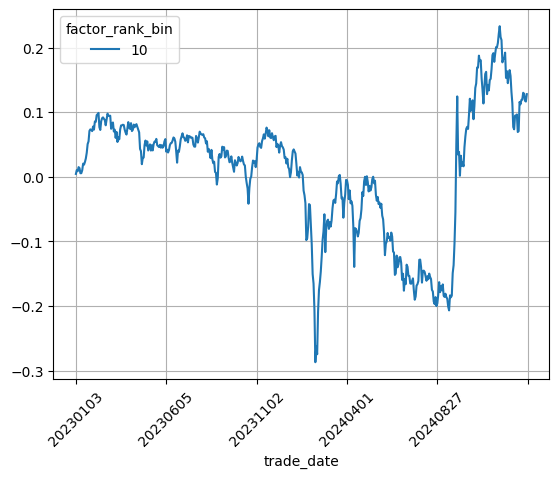

In [ ]:
(test.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<Axes: xlabel='trade_date'>

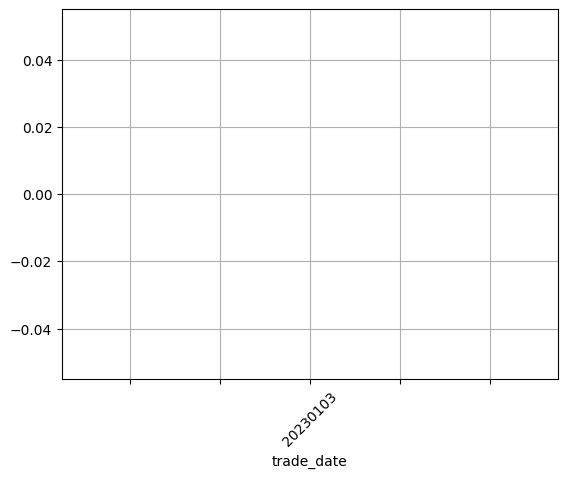

In [ ]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (test[(test.factor_rank_bin == 10)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [ ]:
ret_PD = (test.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


KeyError: 1

In [ ]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

KeyError: 1

## 固定买入N支

<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

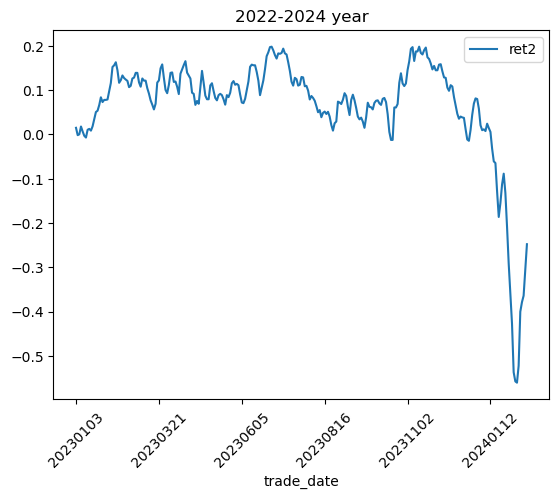

In [ ]:
## 考虑t+1开盘买 t+2收盘卖的收益情况
tmp = test.copy()
tmp = tmp[~tmp.close.isna()].reset_index(drop=True)
# tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('trade_date').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('trade_date').ret2.mean() - 1.0005)
(ret_pd1.loc['20220101':,] ).cumsum().plot(rot=45, title = '2022-2024 year')


In [ ]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('trade_date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [ ]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.22891,-0.621551,0.023193,0.462121,-0.632812


## 对冲收益

In [ ]:
## 计算对冲的收益
dfindex = pro.index_daily(ts_code='000852.SH', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])   #zz1000
# dfindex = pro.index_daily(ts_code='399905.SZ', start_date=ret_pd1.index[0], end_date=ret_pd1.index[-1])  #zz500
dfindex = dfindex[['trade_date','pct_chg']].set_index('trade_date').sort_index()
dfindex

,pct_chg
trade_date,
20230103,2.2618
20230104,-0.0377
20230105,0.9997
20230106,0.2290
20230109,0.5450
...,...
20240207,4.4726
20240208,4.0697
20240219,0.7306


In [ ]:
ret_pd_concat = pd.merge(ret_pd1,dfindex/100,left_index=True, right_index=True)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
trade_date,,,
20230103,0.014648,0.022618,-0.007970
20230104,-0.016602,-0.000377,-0.016225
20230105,0.001953,0.009997,-0.008044
20230106,0.017578,0.002290,0.015288
20230109,-0.011230,0.005450,-0.016680
...,...,...,...
20240207,0.122070,0.044726,0.077344
20240208,0.021484,0.040697,-0.019213
20240219,0.014648,0.007306,0.007342


In [ ]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,0.205168,0.850024
dfindex,0.205168,1.000000,-0.341141
diff,0.850024,-0.341141,1.000000


<AxesSubplot:title={'center':'2022-2024 year'}, xlabel='trade_date'>

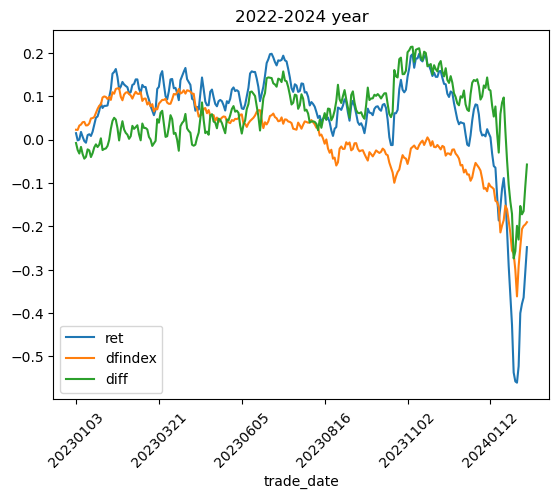

In [ ]:
(ret_pd_concat[['ret','dfindex','diff']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [ ]:
calc_pfmc(ret_pd_concat[['diff']])

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.05314,-0.138577,0.024156,0.479853,-0.402041
